In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
CHANNELS = 3
EPOCH = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "/kaggle/input/breast-cancer-data/augmented_data",
    shuffle=True,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1966 files belonging to 4 classes.


In [4]:
def get_dataset_partitions_tf(ds, train_split = 0.80, val_split =0.1 , test_split =0.1,shuffle = True ,shuffle_size = 10000 ):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds , val_ds,test_ds

In [5]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size  =AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size  =AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
base_model.trainable = False

58900480/58889256 [==============================] - 2s 0us/step


In [10]:
initial_learning_rate = 0.001
dropout_rate = 0.5
weight_decay = 0.0001
patience = 5
factor = 0.5

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model3 = models.Sequential([
    base_model,
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.BatchNormalization(), 
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Dense(n_classes, activation='softmax')

])

model3.build(input_shape = input_shape)

In [12]:
model3.compile(optimizer = 'adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
#checkpoint to save best model per epoch
model_filepath = "/content/drive/MyDrive/model/model3v2/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    verbose=1
)

callbacks_list = [checkpoint, early_stopping]

In [14]:
import time

# Record the start time
start_time = time.time()

In [15]:
history3 = model3.fit(
    train_ds,
    validation_data = val_ds,
    epochs =50,
    callbacks=[early_stopping]
)

Epoch 1/50
98/98 [==============================] - 50s 272ms/step - loss: 1.4962 - accuracy: 0.3768 - val_loss: 1.3801 - val_accuracy: 0.4323
Epoch 2/50
98/98 [==============================] - 14s 144ms/step - loss: 1.3351 - accuracy: 0.4457 - val_loss: 1.3430 - val_accuracy: 0.4635
Epoch 3/50
98/98 [==============================] - 14s 144ms/step - loss: 1.2495 - accuracy: 0.4751 - val_loss: 1.4302 - val_accuracy: 0.3802
Epoch 4/50
98/98 [==============================] - 14s 144ms/step - loss: 1.1627 - accuracy: 0.5243 - val_loss: 1.3302 - val_accuracy: 0.4427
Epoch 5/50
98/98 [==============================] - 14s 145ms/step - loss: 1.1192 - accuracy: 0.5441 - val_loss: 1.3695 - val_accuracy: 0.4271
Epoch 6/50
98/98 [==============================] - 14s 145ms/step - loss: 1.0522 - accuracy: 0.5607 - val_loss: 1.3224 - val_accuracy: 0.4115
Epoch 7/50
98/98 [==============================] - 14s 144ms/step - loss: 1.0380 - accuracy: 0.5971 - val_loss: 1.2744 - val_accuracy: 0.4323

In [19]:
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 580.8405480384827 seconds


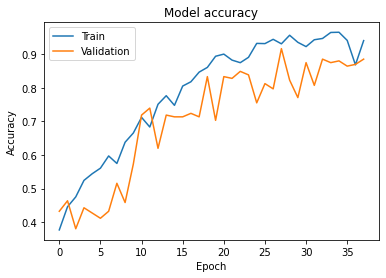

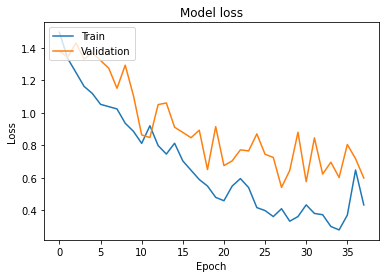

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
class_names = dataset.class_names
class_names

['Benign', 'InSitu', 'Invasive', 'Normal']

In [24]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming class_names is a list containing the names of your classes
class_names = class_names

# Get predictions on the test set
predictions = model3.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels_ds = test_ds.map(lambda x, y: y)
true_labels = np.concatenate(list(true_labels_ds.as_numpy_iterator()))

# Print classification report with class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)


              precision    recall  f1-score   support

      Benign       0.91      0.85      0.88        48
      InSitu       0.98      0.87      0.92        62
    Invasive       0.86      0.96      0.91        51
      Normal       0.90      0.98      0.94        47

    accuracy                           0.91       208
   macro avg       0.91      0.92      0.91       208
weighted avg       0.92      0.91      0.91       208

